In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import stats
from tqdm.notebook import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator

from function.seqfilter import SeqFilter
from function.conserve import ConserveByWeb
from function.conserve import ConservePeraa
from function.conserve import ConserveStandalone
from function.utilities import get_taxid_dict
from function.utilities import get_protein_name
from function.utilities import get_fasta_seq_info
from function.utilities import get_uniprot_rawdata
from function.utilities import find_human_sequence

# Param

In [2]:
#####CHANGE HERE#####
algorithm = "VSL2" #VLXT, VSL2, VL3-BA, fidpnn
uniprot_id = "Q99717" # 'Q13148','P35637', 'P49790', 'Q8NDV7'
conserve_method = 'jsd' #['shannon_entropy','jsd']
#####CHANGE HERE#####

In [3]:
#see tax
tax_ids = [7711, 7742, 32523, 40674]

#order/disorder length criteria
order_filter_length = 10
disorder_filter_length = 40

#conserve_method config, only for shannon_entropy and jsd
#same as https://compbio.cs.princeton.edu/conservation/score.html
normalize = True 
windows_size = 0
sequence_weight = False

#fig2b amino acid show order
conserve_peraa_sort = ["A","C","D","E","G","H","I","K","L","M","N","P","Q","R","S","T","V","F","W","Y"]

#path
input_path = Path("./output/fasta/d_extre_filtered")
fig2_path = Path("./output/fig2") / Path(conserve_method) #for figure 2
table_homology_path = Path("./output/table_homology") #for homologous table

# Load uniprot and order/disorder identification data

In [4]:
human_uniprot_path = Path("./rawdata/human_uniprot.tab")
human_df = get_uniprot_rawdata(human_uniprot_path)

pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")
od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))

In [5]:
human_df

,uniprot_id,gene_name,protein_name,protein_sequence,taxonomy
0,Q96R72,OR4K3,Olfactory receptor 4K3 (Olfactory receptor OR1...,MAWSNQSAVTEFILRGLSSSLELQIFYFLFFSIVYAATVLGNLLIV...,9606
1,Q9UKL2,OR52A1,Olfactory receptor 52A1 (HPFH1OR) (Odorant rec...,MSISNITVYMPSVLTLVGIPGLESVQCWIGIPFCAIYLIAMIGNSL...,9606
2,Q9H205,OR2AG1,Olfactory receptor 2AG1 (HT3) (Olfactory recep...,MELWNFTLGSGFILVGILNDSGSPELLCATITILYLLALISNGLLL...,9606
3,Q8NGN2,OR10S1,Olfactory receptor 10S1 (Olfactory receptor OR...,MTSRSVCEKMTMTTENPNQTVVSHFFLEGLRYTAKHSSLFFLLFLL...,9606
4,Q8NGC1,OR11G2,Olfactory receptor 11G2 (Olfactory receptor OR...,MHFLSQNDLNINLIPHLCLHRHSVIAGAFTIHRHMKIFNSPSNSST...,9606
...,...,...,...,...,...
20391,Q8WVZ7,RNF133,E3 ubiquitin-protein ligase RNF133 (EC 2.3.2.2...,MHLLKVGTWRNNTASSWLMKFSVLWLVSQNCCRASVVWMAYMNISF...,9606
20392,P05387,RPLP2,60S acidic ribosomal protein P2 (Large ribosom...,MRYVASYLLAALGGNSSPSAKDIKKILDSVGIEADDDRLNKVISEL...,9606
20393,P51991,HNRNPA3,Heterogeneous nuclear ribonucleoprotein A3 (hn...,MEVKPPPGRPQPDSGRRRRRRGEEGHDPKEPEQLRKLFIGGLSFET...,9606
20394,Q9BZX4,ROPN1B,Ropporin-1B (Rhophilin-associated protein 1B),MAQTDKPTCIPPELPKMLKEFAKAAIRAQPQDLIQWGADYFEALSR...,9606


# Conservation Score

In [6]:
def get_only_human_score(score, fasta_path):
    """
    get entropy score when alignment positions on human sequences aren't gap

    score: list, entropy score calculated by get_conserve_score()
    fasta_path: fasta file path
    
    return: list, score as same length with human sequence
    """
    nogap_score = []
    nogap = np.array(list(find_human_sequence(fasta_path)["sequence"])) != "-"
    nogap_index = np.where(nogap)[0].tolist()
    for index in nogap_index:
        nogap_score.append(score[index])
        
    return nogap_score

def get_normalize_by_chordata(conserve_list):
    """
    get normalized score while mean and std is derived from chordata sequence
    
    conserve_list: list, list of conservation info from get_conserve_score()
    
    return: list, list of conservation info with normalized score
    """
    #get mean and std
    z_score_base = np.array(conserve_list[0]['score'])
    mean = z_score_base.mean()
    std = z_score_base.std()
    
    #get z-score
    score = np.stack([i['score'] for i in conserve_list])
    score = (score - mean) / std
    
    #put back to conserve_list
    for index, element in enumerate(score):
        element = element.tolist()
        conserve_list[index]['score'] = element
        
    return conserve_list

In [7]:
def get_conserve_score(tax_id, uniprot_id):
    """
    get conserve score with many info for plot
    
    tax_id: int, taxonomy id, i.e. 7711
    uniprot_id: str, uniprot id
    
    return: dict, conserve score with many info
    """
    # read fasta
    fasta_path = input_path / str(tax_id) / "{}.fasta".format(uniprot_id)

    # get conserve score
    # source code: Capra JA and Singh M. Predicting functionally important residues from sequence conservation.
    #              Bioinformatics, 23(15):1875-82, 2007. [Bioinformatics]          
    conserve_score = conservestandalone.get_conserve_score(fasta_path, 
                                                           method=conserve_method, 
                                                           windows_size=windows_size,
                                                           sequence_weight=sequence_weight)
    
    # get conserve score 
    # by web crawler from https://compbio.cs.princeton.edu/conservation/ 
    #conserve_score = conservebyweb.get_conserve_score(fasta_path, 
    #                                                  method=conserve_method, 
    #                                                  windows_size=windows_size,
    #                                                  sequence_weight=sequence_weight)

    # only nogap conserve_score
    conserve_score = get_only_human_score(conserve_score, fasta_path)

    # get order disorder region by PONDR algorithm
    od_ident = od_human_df[od_human_df["uniprot_id"] == uniprot_id]["od_ident"].values[0]  
    od_ident = seqfilter.length_filter_by_od_ident(od_ident=od_ident, 
                                                   disorder_filter_length=disorder_filter_length, 
                                                   order_filter_length=order_filter_length)

    # conservation score and od_ident length error handle, 
    # due to different sequence record between OMA and uniprot but their uniprot_ids are the same
    if len(conserve_score) != len(od_ident):
        raise Exception("{} lenth of conservation score is not equal with od_ident".format(uniprot_id))
        
    # get disorder region after length check
    region = seqfilter.get_od_index(od_ident)

    # get human sequence without gap for disorder plot
    human_sequence = find_human_sequence(fasta_path)["remove_gap_sequence"]

    # get infos
    taxonomy = get_taxid_dict()[tax_id]
    gene_name = get_protein_name(uniprot_id, human_df)["gene_name"]
    homologous_info = get_fasta_seq_info(fasta_path)["homologous_info"]

    return {
        "uniprot_id": uniprot_id,
        "gene_name": gene_name,
        "tax_id": tax_id,
        "taxonomy": taxonomy,
        "score": conserve_score,
        "od_ident": od_ident,
        "human_sequence": human_sequence,
        "region": region,
        "homologous_info":homologous_info
    }

In [8]:
def get_conserve_peraa_score(conserve_list):
    """
    get conserve score per amino acid
    
    conserve_list: list, conserve info by get_conserve_score()
    
    return: dict, conserve score with many info
    """
    # array's dim: 2(aa content/peraa conserve), 2(order/disorder), 20(A, C, D, E...), 4(taxonomy id)
    peraa_score = np.zeros((2, 2, 20, len(conserve_list)))
    
    taxonomy_list = []
    
    for tax_index, i in enumerate(conserve_list):
        
        #make tax list
        taxonomy_list.append(i['taxonomy'])
        
        # read fasta
        fasta_path = input_path / str(i['tax_id']) / "{}.fasta".format(i['uniprot_id'])
        
        # get conserve score and aa content
        info_dict = conserveperaa.get_aa_info(fasta_path, i['score'], i['od_ident'])
        order_conserve, order_content = (info_dict["conserve"]["order"], info_dict["content"]["order"])
        disorder_conserve, disorder_content = (info_dict["conserve"]["disorder"], info_dict["content"]["disorder"])
        
        # put into array
        for aa_index, element in enumerate(conserve_peraa_sort):
            peraa_score[0][0][aa_index][tax_index] = order_content[element]
            peraa_score[0][1][aa_index][tax_index] = disorder_content[element]
            peraa_score[1][0][aa_index][tax_index] = order_conserve[element]
            peraa_score[1][1][aa_index][tax_index] = disorder_conserve[element]
 
    return {
        "uniprot_id": i['uniprot_id'],
        "gene_name": i['gene_name'],
        "taxonomy": taxonomy_list,
        "conserve_peraa_sort": conserve_peraa_sort,
        "peraa_score": peraa_score,
    }

In [9]:
#calcuate conserve score given tax_id
seqfilter = SeqFilter()
conserveperaa = ConservePeraa()
conservestandalone = ConserveStandalone()
# get conserve score by web crawler
# conservebyweb = ConserveByWeb() 

conserve_list = []

t = trange(len(tax_ids), leave=True)
for i in t:
    t.set_description(str(tax_ids[i]))
    t.refresh()

    conserve = get_conserve_score(tax_id=tax_ids[i], uniprot_id=uniprot_id)
    conserve_list.append(conserve)
    
#conserce score normalization
if normalize:
    conserve_list = get_normalize_by_chordata(conserve_list)
    
#calculate peraa score 
conserve_peraa = get_conserve_peraa_score(conserve_list)

  0%|          | 0/4 [00:00<?, ?it/s]

# Plot

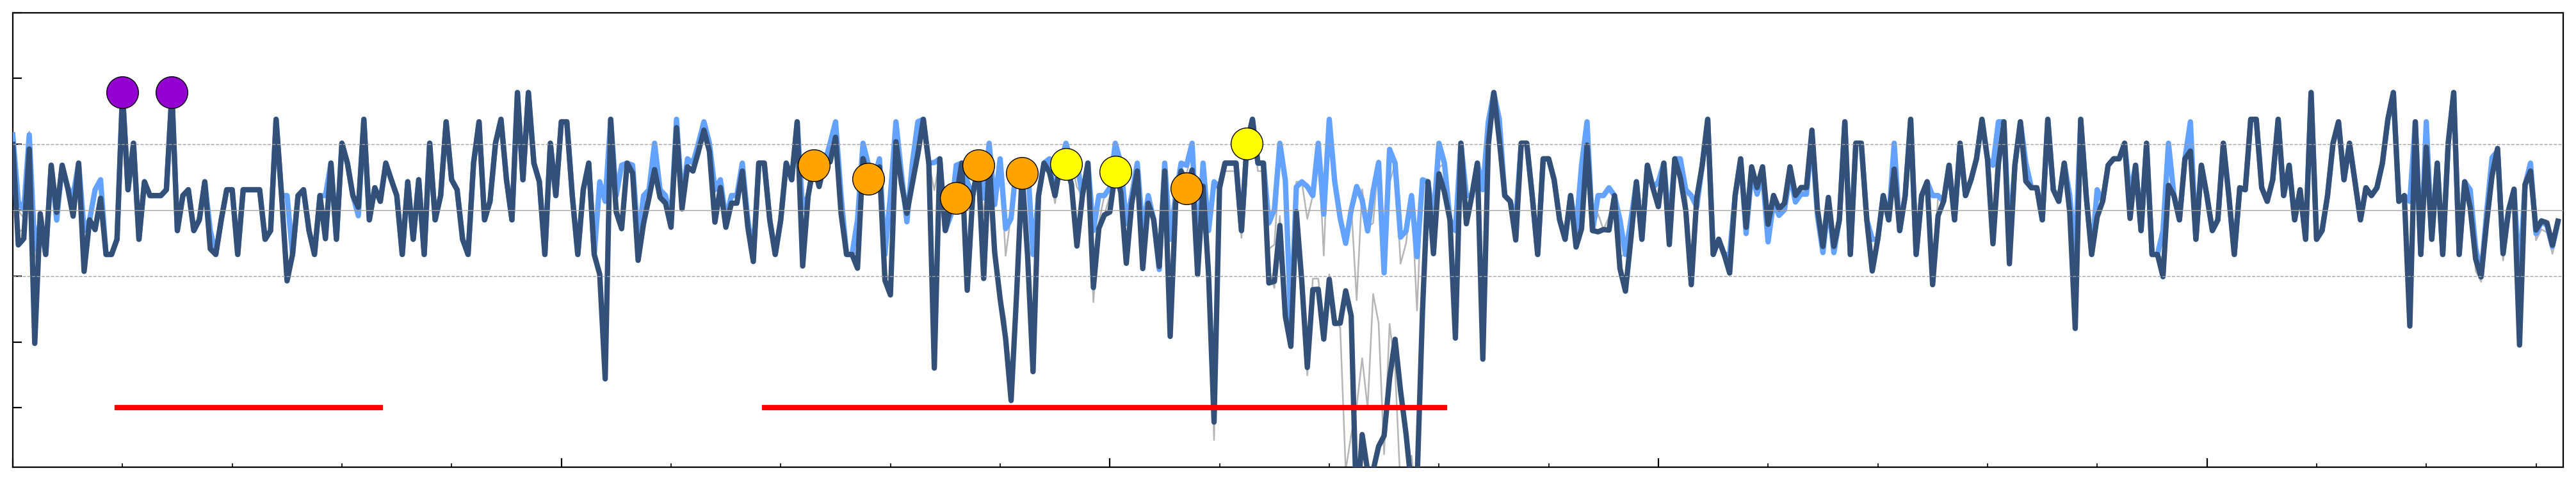

In [10]:
f, (a0) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3.63), dpi=200)

for i in conserve_list:

    # line
    if i["taxonomy"] == "chordata":
        a0.plot(i["score"], color="#335079", zorder=100, linewidth=3)
    elif i["taxonomy"] == "vertebrata":
        a0.plot(i["score"], color="#b5b5b5", zorder=2, linewidth=0.9)
    elif i["taxonomy"] == "tetrapoda":
        a0.plot(i["score"], color="#b5b5b5", zorder=2, linewidth=0.9)
    elif i["taxonomy"] == "mammalia":
        a0.plot(i["score"], color="#63a2fe", zorder=90, linewidth=3)

#disorder plot
for region in conserve_list[0]["region"]["disorder_region"]:
    start = region["start"]
    start = start / len(conserve_list[0]["human_sequence"])
    end = region["end"]
    end = end / len(conserve_list[0]["human_sequence"])
    a0.axhline(-3, start, end, color="#ff0000", linewidth=3, zorder=200)
    
#0 line
a0.axhline(0 , color="#a2a2a2", linewidth=0.5, zorder=100)
a0.axhline(1 , color="#a2a2a2", linewidth=0.5, linestyle='--', zorder=100)
a0.axhline(-1, color="#a2a2a2", linewidth=0.5, linestyle='--', zorder=100)

#WYF point
for index, (od, aa, score) in enumerate(
    zip(conserve_list[0]["od_ident"], conserve_list[0]["human_sequence"], conserve_list[0]["score"])):
    if od == "1":
        if aa == "Y":
            a0.scatter(index, score, s=320, color="#ffff00", edgecolors="black", linewidths=0.5, zorder=200)
        elif aa == "F":
            a0.scatter(index, score, s=320, color="#ffa300", edgecolors="black", linewidths=0.5, zorder=200)
        elif aa == "W":
            a0.scatter(index, score, s=320, color="#9400d1", edgecolors="black", linewidths=0.5, zorder=200)

#style
a0.set_xlim(0, len(i["score"]))
a0.set_ylim(-3.9, 3)

a0.xaxis.set_major_locator(MultipleLocator(100))
a0.xaxis.set_minor_locator(MultipleLocator(20))
a0.yaxis.set_major_locator(MultipleLocator(1))
# a0.yaxis.set_minor_locator(MultipleLocator(0.5))

a0.tick_params(which='major', axis="x",direction="in", length=5)
a0.tick_params(which='minor', axis="x",direction="in", length=2)
a0.tick_params(which='major', axis="y",direction="in", length=5)
a0.tick_params(which='minor', axis="y",direction="in", length=2)

a0.axes.xaxis.set_ticklabels([])
a0.axes.yaxis.set_ticklabels([])

title = "{} ({})".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"], fontsize=12)
# a0.set_title(title, loc="left")
# a0.set_xlabel("Residue Number", fontsize=12)
# a0.set_ylabel("Conservation Level (Z-score)", fontsize=12)

plt.tight_layout(pad=0.3)

#savefig
path = fig2_path / "{}_{}_fig2up".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
f.savefig("{}.svg".format(str(path)))

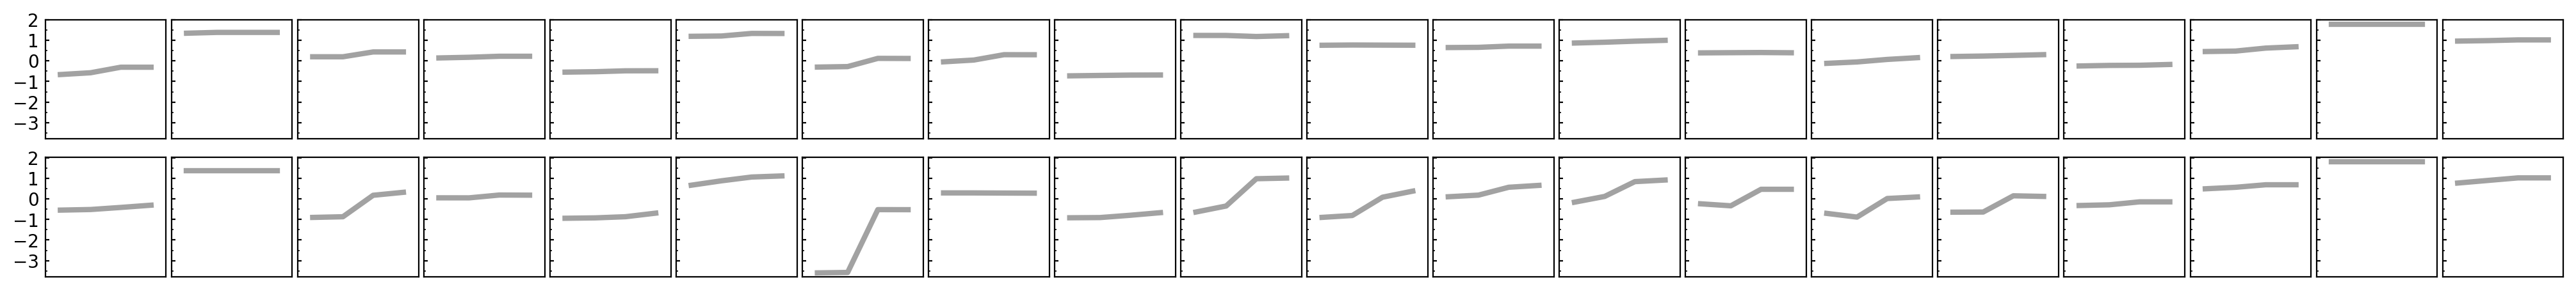

In [11]:
# array's dim: 2(aa content/peraa conserve), 2(order/disorder), 20(A, C, D, E...), 4(taxonomy id)
f, (order,disorder) = plt.subplots(2, 20, sharex=True, sharey=True, figsize=(20, 2.2), dpi=200)

y_max = np.nanmax(conserve_peraa['peraa_score'][1]) + 0.22
y_min = np.nanmin(conserve_peraa['peraa_score'][1]) - 0.2

for index, sub in enumerate(order):
    sub.plot(conserve_peraa['peraa_score'][1][0][index], linestyle="solid", color="#a2a2a2",linewidth=3)
    sub.set_xlim(-0.5, 3.5)
    sub.set_ylim(y_min, y_max)

#     sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=2)
    sub.tick_params(which='minor', axis="y",direction="in", length=1)
    
    sub.yaxis.set_major_locator(MultipleLocator(1))
    sub.yaxis.set_minor_locator(MultipleLocator(0.5))
    
    yticks = sub.yaxis.get_major_ticks()
#     yticks[1].label.set_visible(False)
    
for index, sub in enumerate(disorder):
    sub.plot(conserve_peraa['peraa_score'][1][1][index], linestyle="solid", color="#a2a2a2",linewidth=3)
    
#     sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=2)
    sub.tick_params(which='minor', axis="y",direction="in", length=1)
    
    sub.yaxis.set_major_locator(MultipleLocator(1))
    sub.yaxis.set_minor_locator(MultipleLocator(0.5))
    
    yticks = sub.yaxis.get_major_ticks()
#     yticks[1].label.set_visible(False)
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.3)

path = fig2_path / "{}_{}_fig2down".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
f.savefig("{}.svg".format(str(path)))

# Output

In [12]:
#homologous output
path = table_homology_path / "{}_{}_homologous.xlsx".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
with pd.ExcelWriter(path) as writer:
    for i in conserve_list:
        df = pd.DataFrame(columns=['oma_protein_id','species','taxon_id','oma_cross_reference'])
        taxonomy = i['taxonomy']
        for j in i['homologous_info']:
            df = df.append({'oma_protein_id': j['oma_protein_id'],
                            'species': j['species'],
                            'taxon_id': j['taxon_id'],
                            'oma_cross_reference': j['oma_cross_reference']},ignore_index=True)
        
        df.to_excel(writer, sheet_name=taxonomy)  

# Overall trend

In [ ]:
from function.utilities import get_subset
input_path = Path("/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp")
uniprot_ids = get_subset(human_df, 'rbp')['uniprot_id'].tolist() 

all_list = []
failed_uids = []
j = trange(len(uniprot_ids), leave=True)
for uniprot_id in j:
    try:
        conserve_list = []

        t = trange(len(tax_ids), leave=False)
        for i in t:
            t.set_description(str(tax_ids[i]))
            t.refresh()

            conserve = get_conserve_score(tax_id=tax_ids[i], uniprot_id=uniprot_ids[uniprot_id])
            conserve_list.append(conserve)


        #conserce score normalize
        if normalize:
            conserve_list = get_normalize_by_chordata(conserve_list)

        #calculate peraa score 
        conserve_peraa = get_conserve_peraa_score(conserve_list)


        all_list.append({"uniprot_id":conserve_peraa['uniprot_id'],
                         "gene_name":conserve_peraa['gene_name'],
                         "peraa_score":conserve_peraa['peraa_score']})
        
    except Exception as e: print(e)

  0%|          | 0/1533 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q6NWY9 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8NDF8.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P18621.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q15415.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A6NFN3 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15910 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5T3I0.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O95758 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q6P5S7.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TG7 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9GZT3 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NBJ9 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q587J7 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

Q9BWF3 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

P49792, fasta path /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P49792.fasta does not have human sequence


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A6NNA2 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P61927.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

O00584, fasta path /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O00584.fasta does not have human sequence


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/A6NDE4.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NI27 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NAT2 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96P11 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P08865.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O75400.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P22626 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q14690.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43251 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P23396 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q14493 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q01085 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q13428 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96IZ7 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O00422 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P49589 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8IYB3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9H1A7.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q5GAN6 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8TB72 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H9P5 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TS9 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NP81, fasta path /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9NP81.fasta does not have human sequence


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O75127, fasta path /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/40674/O75127.fasta does not have human sequence


  0%|          | 0/4 [00:00<?, ?it/s]

Q8IV42 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5VZF2 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H633 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TN4 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NA58 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P0C7P1.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q16637.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P62318.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P78362 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

Q8WXA9 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P60900 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92540 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P47914 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15020 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P82930.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9BV90.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P52435, fasta path /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/40674/P52435.fasta does not have human sequence


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P62847 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9Y3A5.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86V81 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O14787 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

Q7Z5L2 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y3B7 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8TCC3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q05519 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y3T6 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H7E2 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

Q5VZ19 lenth of conservation score is not equal with od_ident


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
no_zero_all_list = []
for i in all_list:
    if not (i['peraa_score'][0][0] == 0).all():
        no_zero_all_list.append(i)       
order_conserve = np.stack([i['peraa_score'][1][0] for i in no_zero_all_list])
order_conserve = np.nanmean(order_conserve,axis=0)
# order_conserve = order_conserve.mean(axis=0)


no_zero_all_list = []
for i in all_list:
    if not (i['peraa_score'][0][1] == 0).all():
        no_zero_all_list.append(i)       
disorder_conserve = np.stack([i['peraa_score'][1][1] for i in no_zero_all_list])
disorder_conserve = np.nanmean(disorder_conserve,axis=0)
# disorder_conserve = disorder_conserve.mean(axis=0)

overall_conserve = np.stack([order_conserve, disorder_conserve])
np.save('overall_conserve.pkl',overall_conserve)

In [20]:
overall_trend_path = Path("./output/peraa_overall_trend")
overall_conserve = np.load('./output/peraa_overall_trend/overall_conserve.pkl.npy')

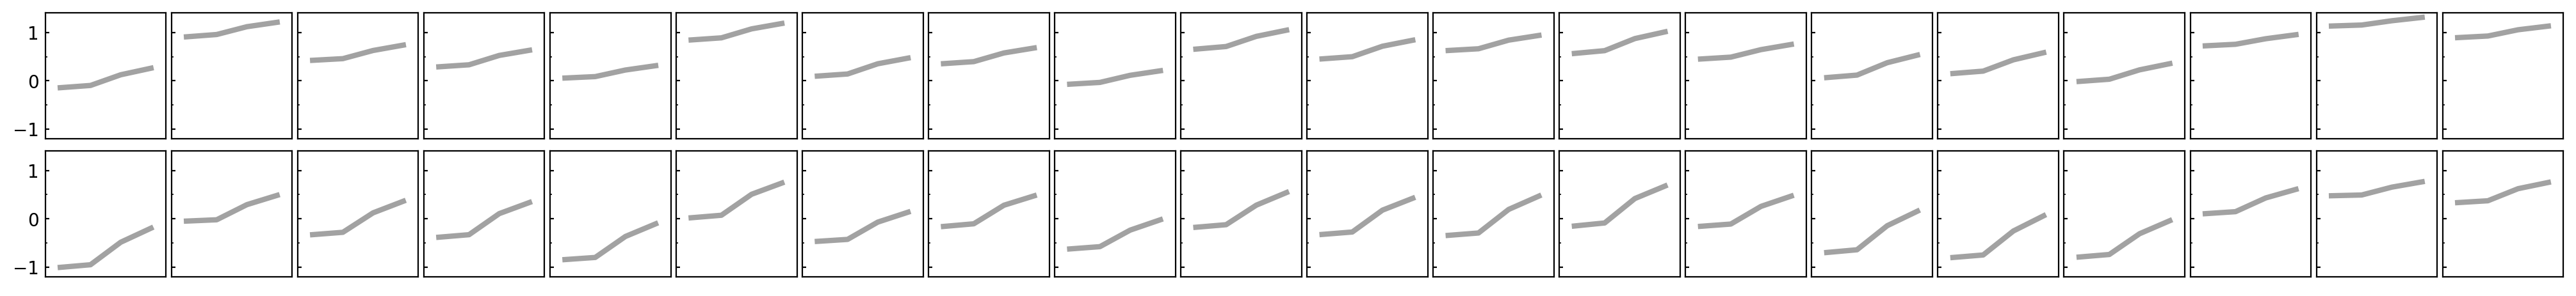

In [21]:
f, (order,disorder) = plt.subplots(2, 20, sharex=True, sharey=True, figsize=(20, 2.2), dpi=200)

y_max = np.nanmax(overall_conserve) + 0.1
y_min = np.nanmin(overall_conserve) - 0.2

for index, sub in enumerate(order):
    sub.plot(overall_conserve[0][index], linestyle="solid", color="#a2a2a2",linewidth=3)
    

#     sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=2)
    sub.tick_params(which='minor', axis="y",direction="in", length=1)
    
    sub.yaxis.set_major_locator(MultipleLocator(1))
    sub.yaxis.set_minor_locator(MultipleLocator(0.5))
    
    yticks = sub.yaxis.get_major_ticks()
#     yticks[1].label.set_visible(False)
    
    
for index, sub in enumerate(disorder):
    sub.plot(overall_conserve[1][index], linestyle="solid", color="#a2a2a2",linewidth=3)
    sub.set_xlim(-0.5, 3.5)
    sub.set_ylim(y_min, y_max)
    
    
#     sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=2)
    sub.tick_params(which='minor', axis="y",direction="in", length=1)
    
    sub.yaxis.set_major_locator(MultipleLocator(1))
    sub.yaxis.set_minor_locator(MultipleLocator(0.5))
    
    yticks = sub.yaxis.get_major_ticks()
#     yticks[1].label.set_visible(False)
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.3)


path = overall_trend_path / "fig2down"
f.savefig("{}.svg".format(str(path)))